# Urban and rural surrounding areas selection

## Load libraries

Here we load the required libraries to execute the notebook. Note that specific code from dedicated scripts (`utils.py`, `urban_areas.py`, ...) is also loaded here.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!echo $CONDA_DEFAULT_ENV

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools


In [3]:
import os

import numpy as np
import pandas as pd
from urclimask.GHCNd_stations import get_valid_timeseries, inside_city
from urclimask.UHI_analysis import UrbanIsland
from urclimask.urban_areas import UrbanVicinity
from urclimask.utils import load_ucdb_city, traverseDir

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
from tools import (
    check_equal_period,
    fix_360_longitudes,
    open_datasets,
    standardize_unit,
)

In [6]:
save_results_path = os.path.abspath(
    os.path.join(os.getcwd(), "..", "intermediate-results")
)
save_figure_path = os.path.abspath(os.path.join(os.getcwd(), "..", "plots"))

# CORDEX-EUR-CMIP6

In [7]:
city = "Paris"
lon_city = 2.35
lat_city = 48.85

domain = "EUR-11"
model = "REMO"
scenario = "evaluation"

urban_var = "sfturf"

urban_th = 40
urban_sur_th = 10
orog_diff = 100
sftlf_th = 70
ratio_r2u = 2
min_city_size = 8
lon_lim = 1
lat_lim = 1

variable = "tasmin"
period_star = "1991"
period_stop = "2020"
period = slice(period_star, period_stop)

domain_resolution = int(domain.split("-")[1])

# CMIP6

In [8]:
mip_era = "CMIP6"
driving_source_id = "ERA5"
frequency = "mon"

In [9]:
dsets = open_datasets(
    [variable],
    frequency=frequency,
    driving_source_id=driving_source_id,
    mask=True,
    add_missing_bounds=False,
)

Opening catalog from https://raw.githubusercontent.com/euro-cordex/joint-evaluation/refs/heads/main/CORDEX-CMIP6.json
Found 14 datasets for variables ['tasmin']: ['RACMO23E', 'COSMO-CLM-6-0-clm3', 'ICON-CLM-202407-1-1', 'CCLM6-0-1-URB', 'HCLIM43-ALADIN', 'ROAM-NBS', 'REMO2020-2-2-iMOVE-LUC', 'REMO2020-2-2-MR2', 'REMO2020-2-2', 'REMO2020-2-2-iMOVE', 'WRF451Q', 'CNRM-ALADIN64E1', 'RegCM5-0', 'ALARO1-SFX']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.domain_id.institution_id.driving_source_id.driving_experiment_id.driving_variant_label.source_id.version_realization.frequency.version'


decoding dataset CORDEX-CMIP6.EUR-12.RMIB-UGent.ERA5.evaluation.r1i1p1f1.ALARO1-SFX.v1-r1.fx.v20241009
Found 28 datasets
decoding dataset CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.ERA5.evaluation.r1i1p1f1.HCLIM43-ALADIN.v1-r1.fx.v20241205
Found 28 datasets
decoding dataset CORDEX-CMIP6.EUR-12.CLMcom-CMCC.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB.v1-r1.fx.v20250201
Found 28 datasets
decoding dataset CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-MR2.v1-r1.fx.v20241120
Found 28 datasets
decoding dataset CORDEX-CMIP6.EUR-12.DWD-BSH.ERA5.evaluation.r1i1p1f1.ROAM-NBS.v1-r1.fx.v20240920
Warning for CORDEX-CMIP6.EUR-12.DWD-BSH.ERA5.evaluation.r1i1p1f1.ROAM-NBS.v1-r1.fx.v20240920: Variable(s) referenced in cell_measures not in variables: ['areacella']
Warning for CORDEX-CMIP6.EUR-12.DWD-BSH.ERA5.evaluation.r1i1p1f1.ROAM-NBS.v1-r1.fx.v20240920: Variable(s) referenced in cell_measures not in variables: ['areacella']
Warning for CORDEX-CMIP6.EUR-12.DWD-BSH.ERA5.evaluation.r1i1p1f1.ROAM-NBS

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/evaltools/evaltools/fix.py:88: UserWarning: Grid mapping has (198.0, 39.25) which is inconsistent with (-162.0, 39.25) for EUR-12 and CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.fx.v20250415.
  warnings.warn(message)
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/evaltools/evaltools/fix.py:88: UserWarning: Grid mapping has (18.0, 39.25) which is inconsistent with (-162.0, 39.25) for EUR-11 and CORDEX-CMIP6.EUR-12.AUTH.ERA5.evaluation.r1i1p1f1.WRF451Q.v1-r3.mon.v20250630.
  warnings.warn(message)
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/evaltools/evaltools/fix.py:88: UserWarning: Grid mapping has (198.0, 39.25) which is inconsistent with (-162.0, 39.25) for EUR-12 and CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.mon.v20250415.
  warnings.warn(message)


fx dataset not found for CORDEX-CMIP6.EUR-12.AUTH.ERA5.evaluation.r1i1p1f1.WRF451Q.v1-r3.mon.v20250630
merging CORDEX-CMIP6.EUR-12.RMIB-UGent.ERA5.evaluation.r1i1p1f1.ALARO1-SFX.v1-r1.mon.v20241009 with CORDEX-CMIP6.EUR-12.RMIB-UGent.ERA5.evaluation.r1i1p1f1.ALARO1-SFX.v1-r1.fx.v20241009
merging CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-iMOVE.v1-r1.mon.v20250515 with CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-iMOVE.v1-r1.fx.v20250515
merging CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2.v1-r1.mon.v20241120 with CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2.v1-r1.fx.v20241120
merging CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-iMOVE-LUC.v1-r1.mon.v20250515 with CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-iMOVE-LUC.v1-r1.fx.v20250515
merging CORDEX-CMIP6.EUR-12.DWD-BSH.ERA5.evaluation.r1i1p1f1.ROAM-NBS.v1-r1.mon.v20240920 with CORDEX-CMIP6.EUR-12.DWD-BSH.ERA5.evalu

In [10]:
# delete simulatios with not urban static variable
to_delete = [dset for dset, ds in dsets.items() if urban_var not in ds.variables]

for dset in to_delete:
    del dsets[dset]

In [11]:
for dset in dsets.keys():
    dsets[dset] = dsets[dset].sel(time=period).compute()

In [12]:
for dset in dsets.keys():
    if not check_equal_period(dsets[dset], period):
        print(f"Temporal coverage of {dset} does not match with {period}")

In [13]:
for dset in dsets.keys():
    dsets[dset] = standardize_unit(dsets[dset], variable)

## Define urban areas and vicinity

In [14]:
### Load city shapefile
root_aux_data = "/mnt/CORDEX_CMIP6_tmp/aux_data/"
ucdb_city = load_ucdb_city(root_aux_data, city)

## Load observations for Paris

In [15]:
var_map = {
    "tas": "TAVG",
    "tasmin": "TMIN",
    "tasmax": "TMAX",
    "pr": "PRCP",
    "sfcWind": "SNWD",
}

In [16]:
root = "/mnt/CORDEX_CMIP6_tmp/aux_data/PARIS_surface_weather_data/"
files_obs_paris = list(traverseDir(root, ".csv"))
files_obs_paris = [f for f in files_obs_paris if "198001" in f]


df_all = []
for file in files_obs_paris:

    if variable == "pr":
        var_paris = "RR1"
    elif variable in ["tas", "tasmax", "tasmin"]:
        var_paris = "T"
    elif variable == "sfcWind":
        var_paris = "FF"

    df = pd.read_csv(file, sep=";", decimal=",", na_values=["", " "])
    df["DATE"] = pd.to_datetime(df["DATE"], format="%Y%m%d%H")
    df.set_index("DATE", inplace=True)
    df = df.sort_index()

    station_code = df["POSTE"].iloc[0]
    station_name = file.split("/")[-1].split("_")[-1].split(".csv")[0]

    if variable == "tasmax":
        df_aux = df[[var_paris]].resample("D").max()
    elif variable == "tasmin":
        df_aux = df[[var_paris]].resample("D").min()
    else:
        df_aux = df[[var_paris]]

    df_var = pd.DataFrame(index=df_aux.index)
    df_var[var_map.get(variable, None)] = df_aux[var_paris]
    df_var["NAME"] = file.split("/")[-1].split("_")[-1].split(".csv")[0]
    df_var["code"] = station_code
    df_all.append(df_var)

df_obs = pd.concat(df_all)

/tmp/ipykernel_534899/2252396539.py:16: DtypeWarning: Columns (3,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
/tmp/ipykernel_534899/2252396539.py:16: DtypeWarning: Columns (3,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
/tmp/ipykernel_534899/2252396539.py:16: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
/tmp/ipykernel_534899/2252396539.py:16: DtypeWarning: Columns (3,7,9,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
/tmp/ipykernel_534899/2252396539.py:16: DtypeWarning: Columns (3,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
/tmp/ipykernel_534899/2252396539.py:16: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
/tmp/ipykernel_534899

### Load static variables
Load static variables, such as urban fraction (sfturf), terrain elevation (orography) or land-sea fraction (sftlf).

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/urclimask/urclimask/urban_areas.py:165: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  cleaned_mask = morphology.remove_small_objects(labeled_mask, min_size=self.min_city_size)
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/urclimask/urclimask/GHCNd_stations.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'{city} -- {stn_data.NAME[0]} - {var} has {100*valid_records:.1f}% valid records in {idate} to {fdate}')
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/urclimask/urclimask/GHCNd_stations.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a com

Paris -- PARIS-MONTSOURIS - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- MELUN - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- TOUSSUS-LE-NOBLE - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- TRAPPES - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- VILLACOUBLAY - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- ORLY - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- BRETIGNY-SAPC - TMIN has 89.9% valid records in 1991-01-01 to 2020-12-31
Paris -- SAINT-MAUR - TMIN has 89.8% valid records in 1991-01-01 to 2020-12-31
Paris -- ROISSY - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
There are 5 series inside the city and 4 outside


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/urclimask/urclimask/urban_areas.py:165: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  cleaned_mask = morphology.remove_small_objects(labeled_mask, min_size=self.min_city_size)
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/urclimask/urclimask/GHCNd_stations.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'{city} -- {stn_data.NAME[0]} - {var} has {100*valid_records:.1f}% valid records in {idate} to {fdate}')


Paris -- PARIS-MONTSOURIS - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- MELUN - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- TOUSSUS-LE-NOBLE - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- TRAPPES - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- VILLACOUBLAY - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- ORLY - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- BRETIGNY-SAPC - TMIN has 89.9% valid records in 1991-01-01 to 2020-12-31
Paris -- SAINT-MAUR - TMIN has 89.8% valid records in 1991-01-01 to 2020-12-31
Paris -- ROISSY - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/urclimask/urclimask/GHCNd_stations.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  valid_obs.loc[valid_obs['code'].str.contains(obs.code), 'inside_city'] = is_inside.values[0]


There are 5 series inside the city and 4 outside


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/urclimask/urclimask/urban_areas.py:165: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  cleaned_mask = morphology.remove_small_objects(labeled_mask, min_size=self.min_city_size)
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/urclimask/urclimask/GHCNd_stations.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'{city} -- {stn_data.NAME[0]} - {var} has {100*valid_records:.1f}% valid records in {idate} to {fdate}')


Paris -- PARIS-MONTSOURIS - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- MELUN - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- TOUSSUS-LE-NOBLE - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- TRAPPES - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- VILLACOUBLAY - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- ORLY - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- BRETIGNY-SAPC - TMIN has 89.9% valid records in 1991-01-01 to 2020-12-31
Paris -- SAINT-MAUR - TMIN has 89.8% valid records in 1991-01-01 to 2020-12-31
Paris -- ROISSY - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/urclimask/urclimask/GHCNd_stations.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  valid_obs.loc[valid_obs['code'].str.contains(obs.code), 'inside_city'] = is_inside.values[0]


There are 5 series inside the city and 4 outside


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/urclimask/urclimask/urban_areas.py:165: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  cleaned_mask = morphology.remove_small_objects(labeled_mask, min_size=self.min_city_size)
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/urclimask/urclimask/GHCNd_stations.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'{city} -- {stn_data.NAME[0]} - {var} has {100*valid_records:.1f}% valid records in {idate} to {fdate}')
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/urclimask/urclimask/GHCNd_stations.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a com

Paris -- PARIS-MONTSOURIS - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- MELUN - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- TOUSSUS-LE-NOBLE - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- TRAPPES - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- VILLACOUBLAY - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- ORLY - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- BRETIGNY-SAPC - TMIN has 89.9% valid records in 1991-01-01 to 2020-12-31
Paris -- SAINT-MAUR - TMIN has 89.8% valid records in 1991-01-01 to 2020-12-31
Paris -- ROISSY - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
There are 5 series inside the city and 4 outside


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/urclimask/urclimask/GHCNd_stations.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'{city} -- {stn_data.NAME[0]} - {var} has {100*valid_records:.1f}% valid records in {idate} to {fdate}')
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/urclimask/urclimask/GHCNd_stations.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  valid_obs.loc[valid_obs['code'].str.contains(obs.code), 'inside_city'] = is_inside.values[0]


Paris -- PARIS-MONTSOURIS - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- MELUN - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- TOUSSUS-LE-NOBLE - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- TRAPPES - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- VILLACOUBLAY - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- ORLY - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- BRETIGNY-SAPC - TMIN has 89.9% valid records in 1991-01-01 to 2020-12-31
Paris -- SAINT-MAUR - TMIN has 89.8% valid records in 1991-01-01 to 2020-12-31
Paris -- ROISSY - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
There are 5 series inside the city and 4 outside


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/urclimask/urclimask/urban_areas.py:165: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  cleaned_mask = morphology.remove_small_objects(labeled_mask, min_size=self.min_city_size)
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/urclimask/urclimask/GHCNd_stations.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'{city} -- {stn_data.NAME[0]} - {var} has {100*valid_records:.1f}% valid records in {idate} to {fdate}')


Paris -- PARIS-MONTSOURIS - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- MELUN - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- TOUSSUS-LE-NOBLE - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- TRAPPES - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- VILLACOUBLAY - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- ORLY - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31
Paris -- BRETIGNY-SAPC - TMIN has 89.9% valid records in 1991-01-01 to 2020-12-31
Paris -- SAINT-MAUR - TMIN has 89.8% valid records in 1991-01-01 to 2020-12-31
Paris -- ROISSY - TMIN has 90.0% valid records in 1991-01-01 to 2020-12-31


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/urclimask/urclimask/GHCNd_stations.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  valid_obs.loc[valid_obs['code'].str.contains(obs.code), 'inside_city'] = is_inside.values[0]


There are 5 series inside the city and 4 outside


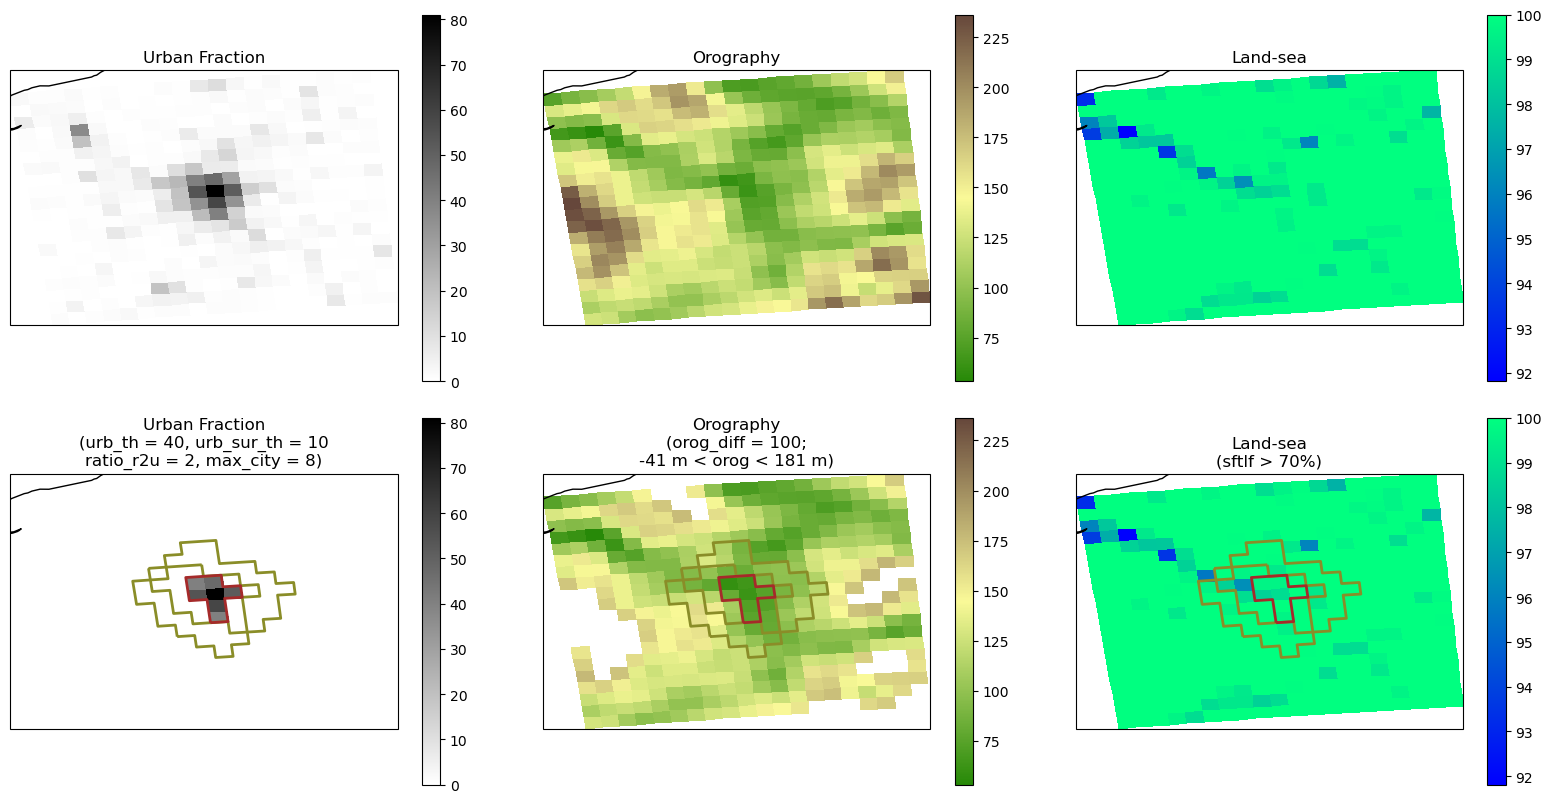

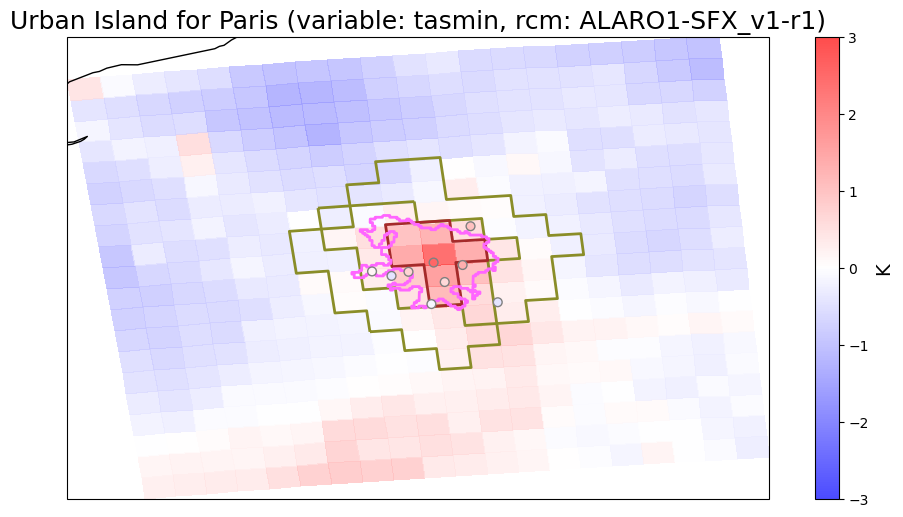

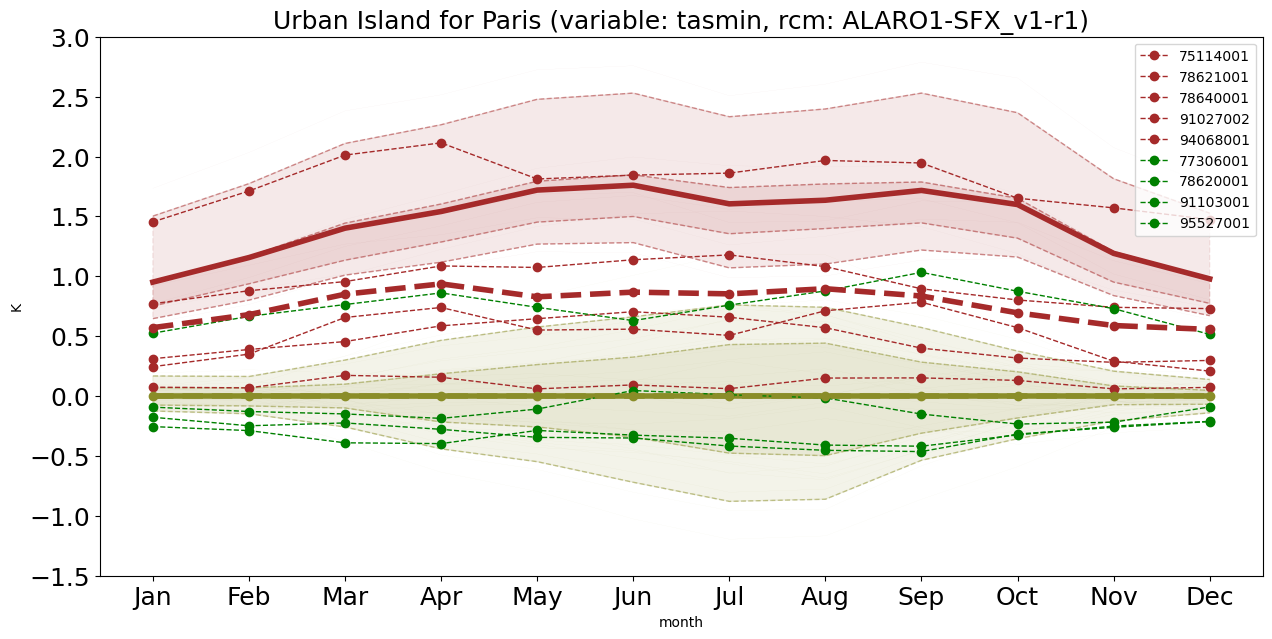

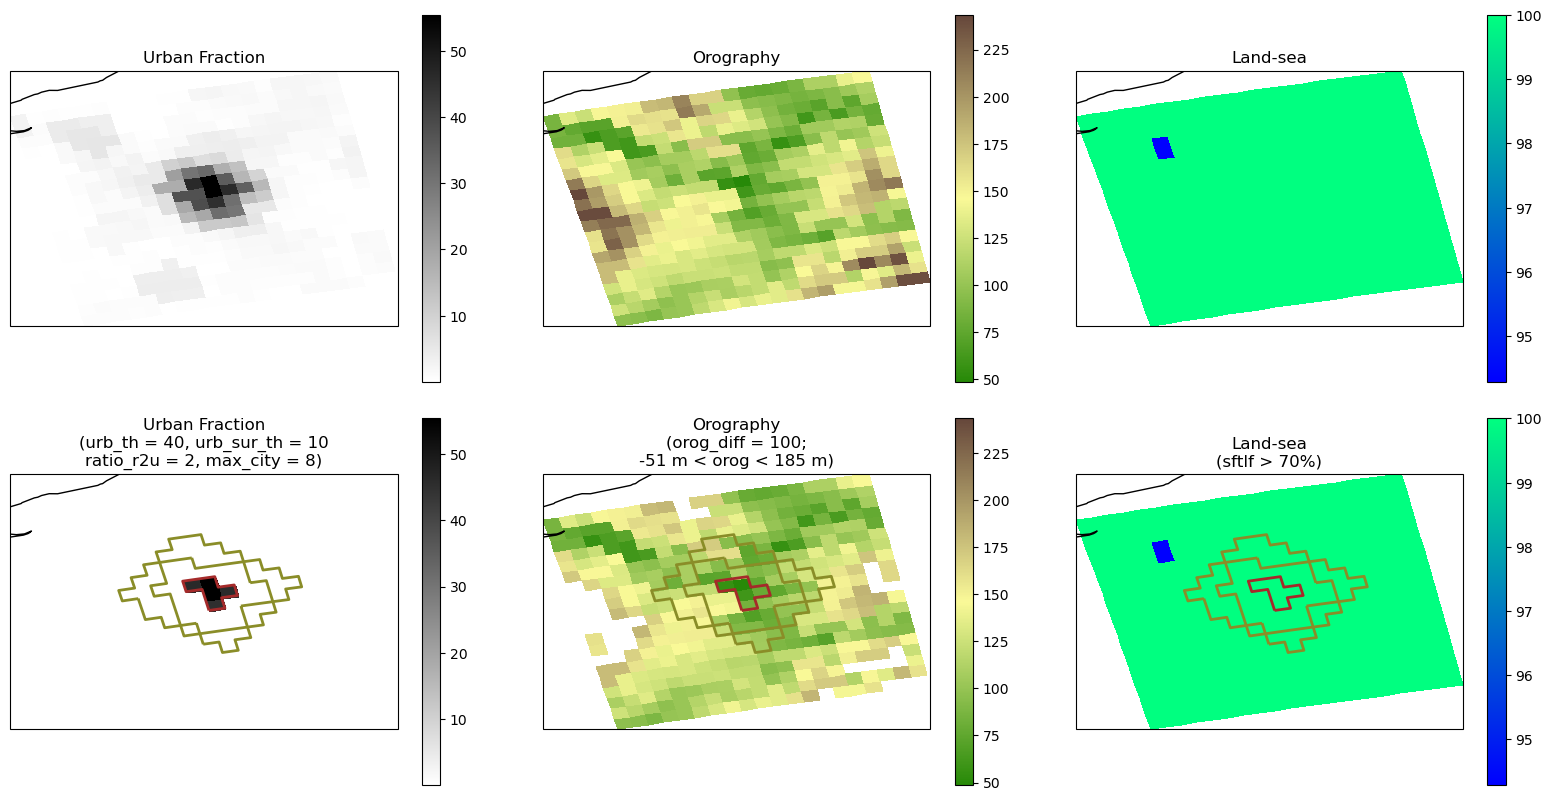

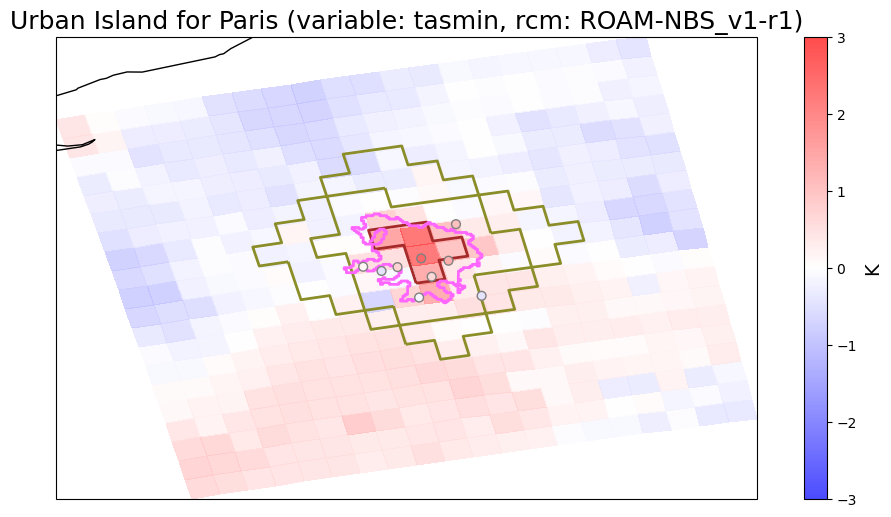

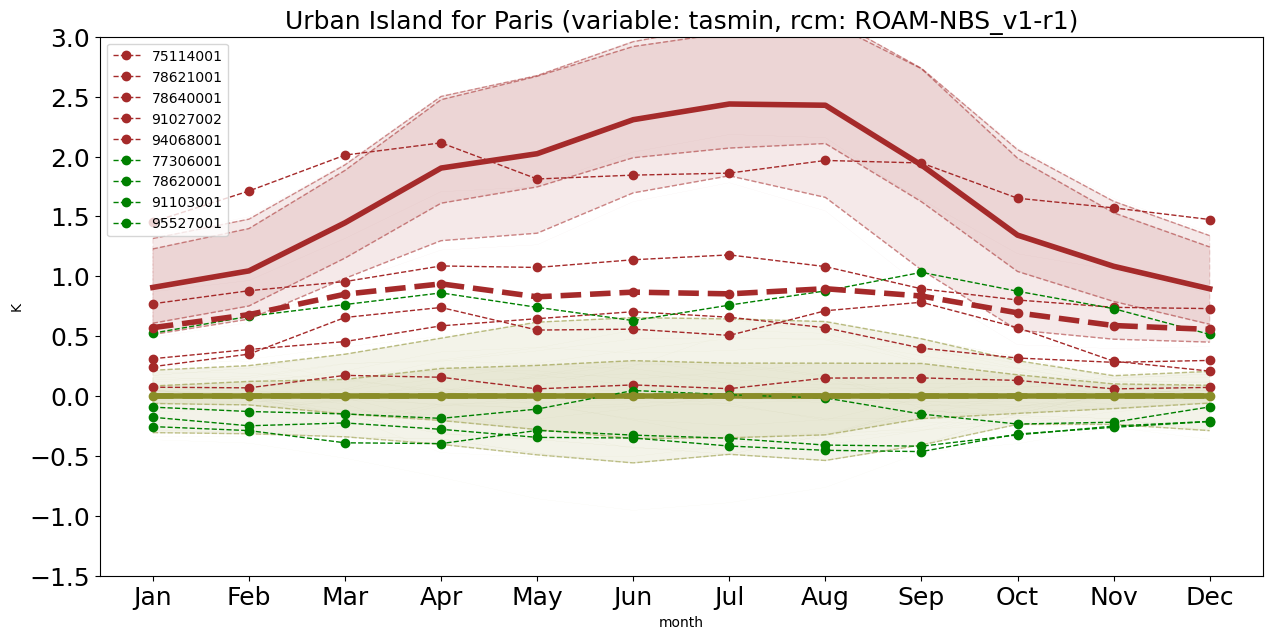

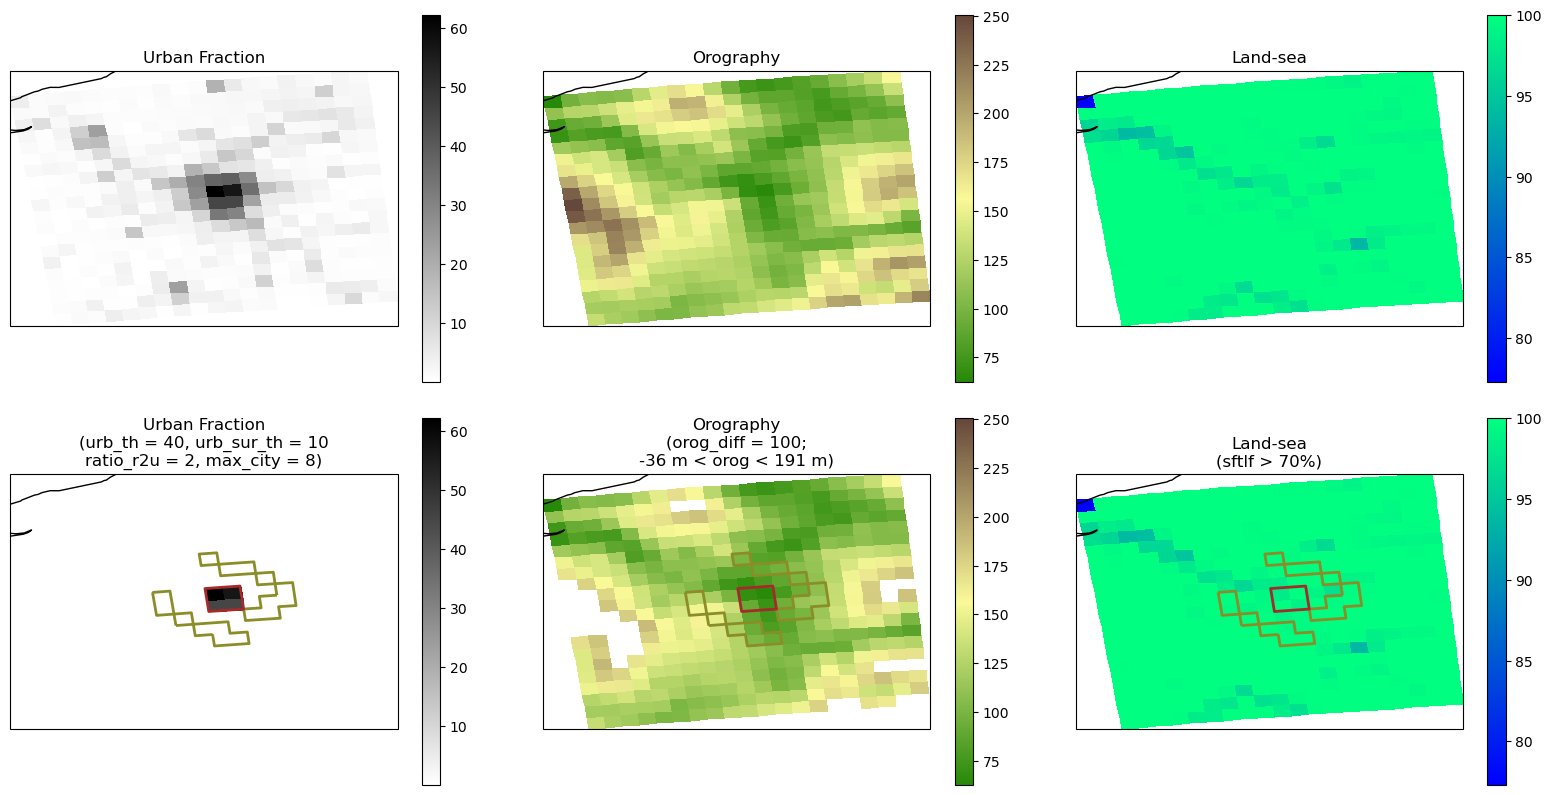

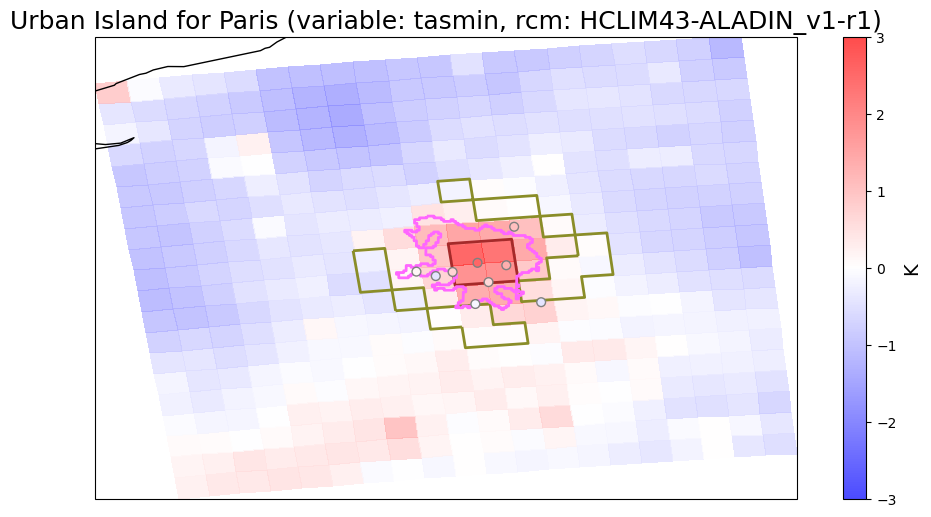

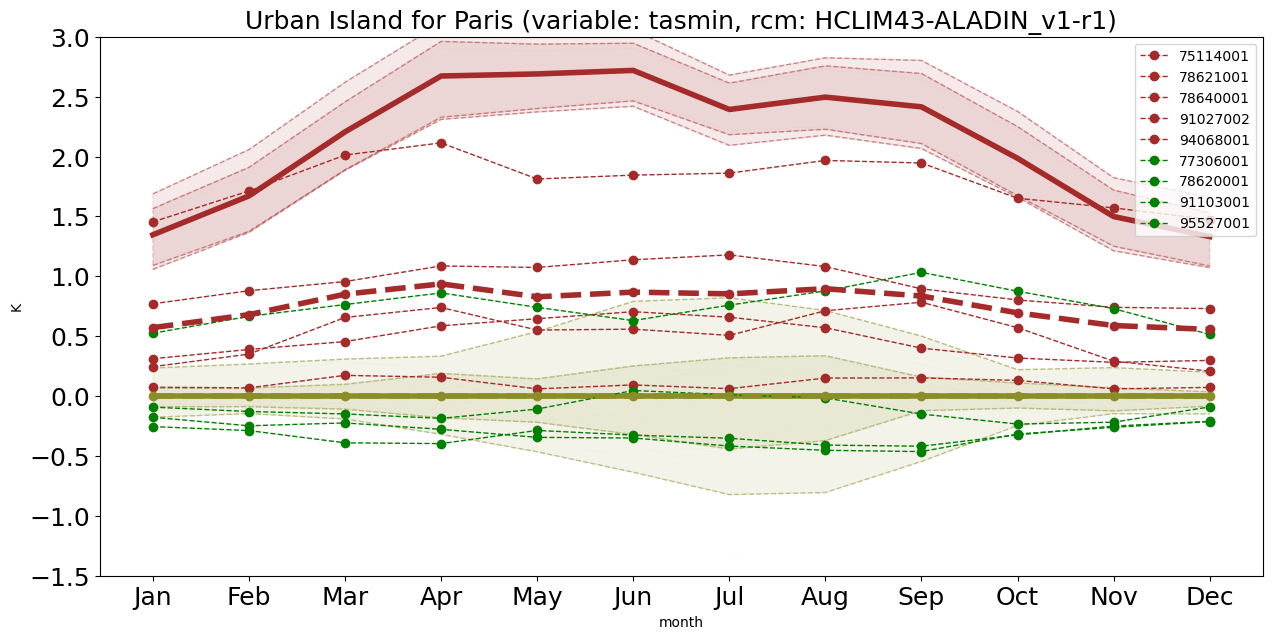

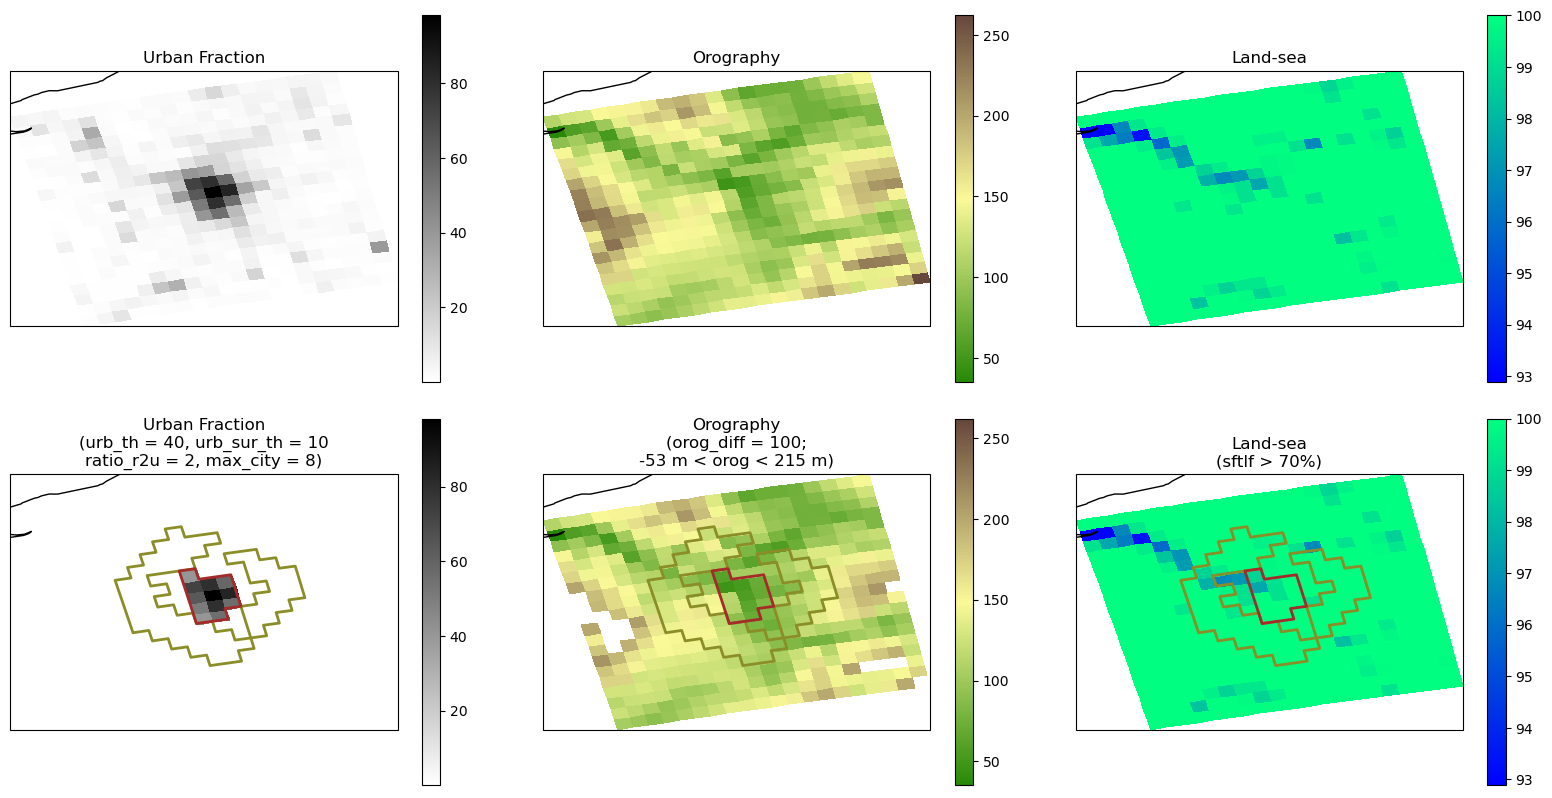

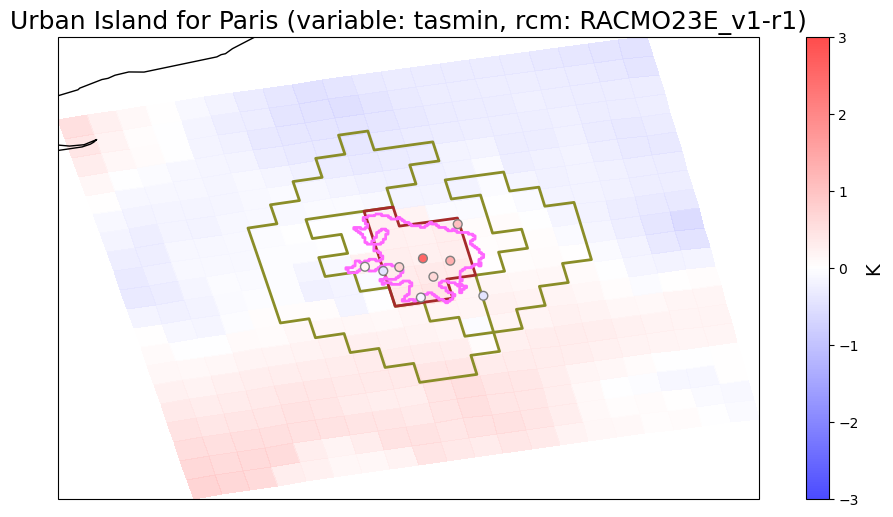

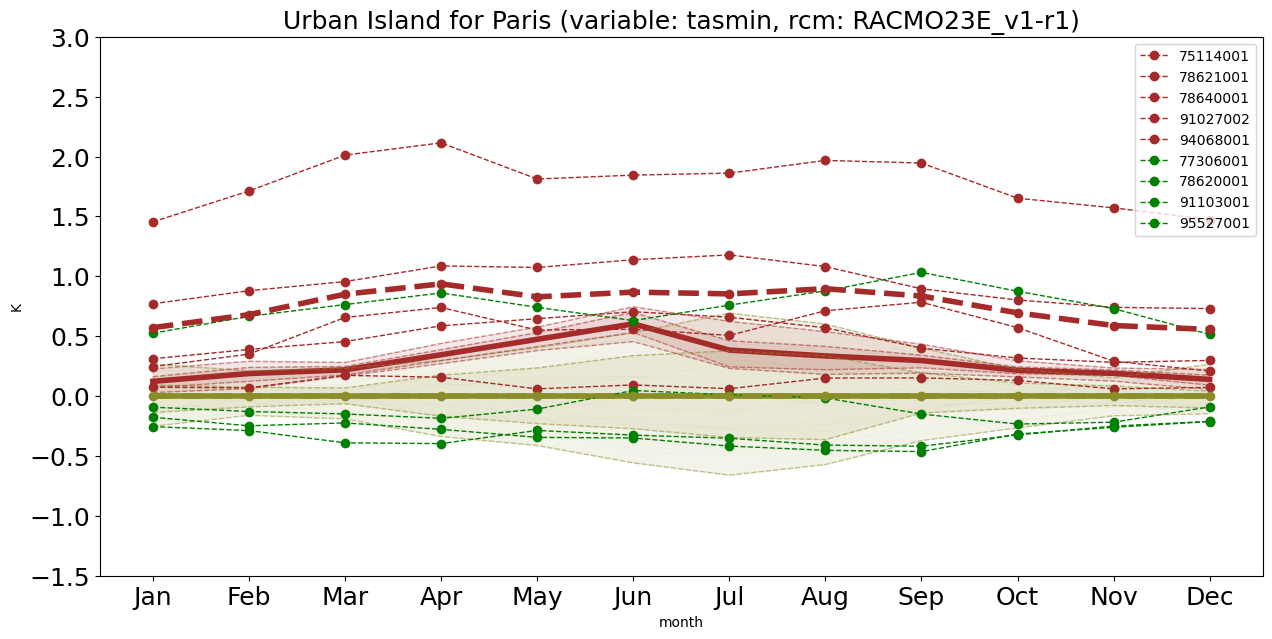

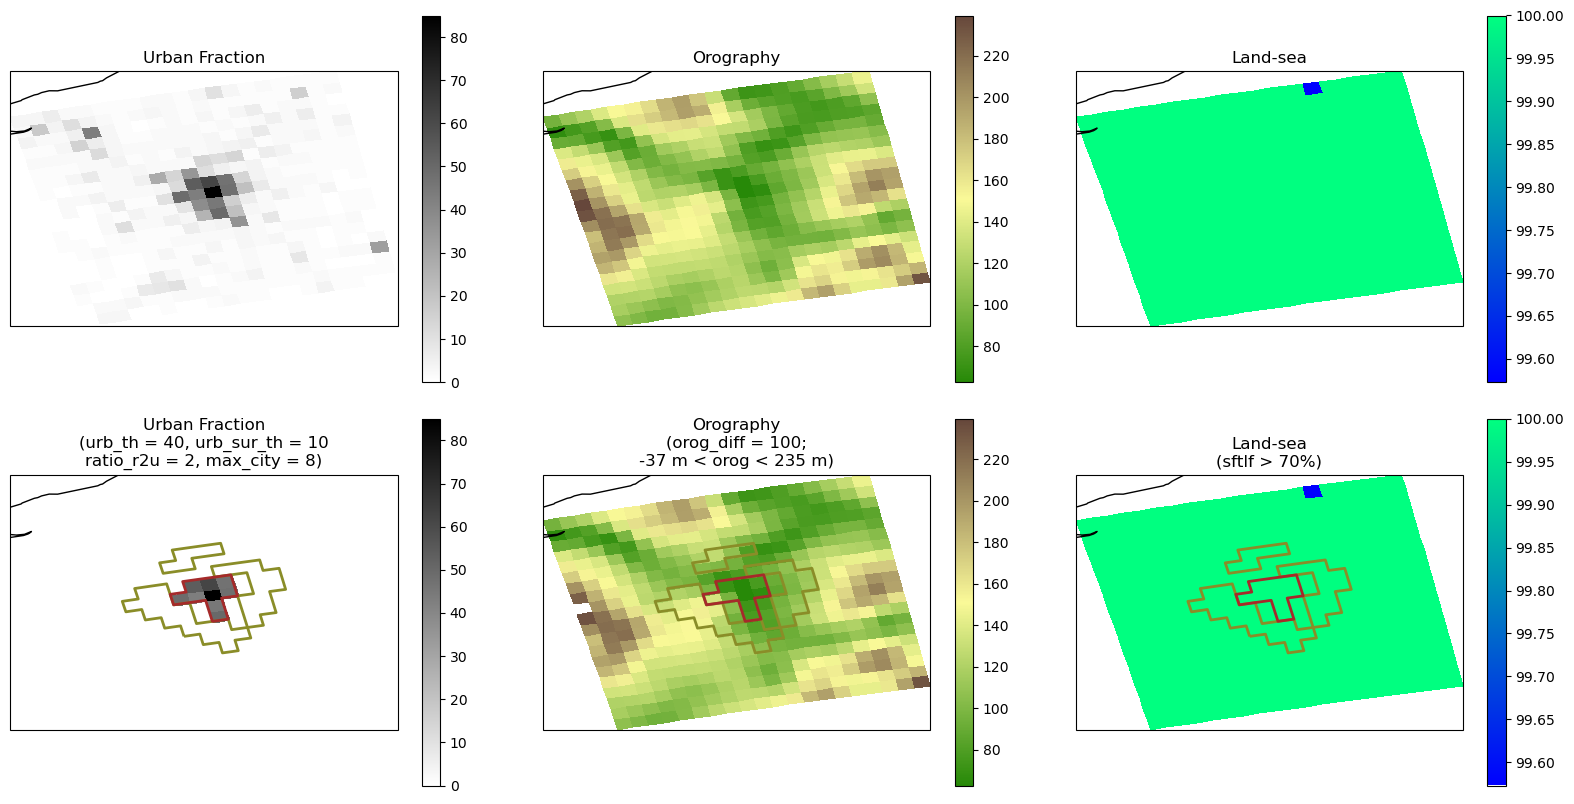

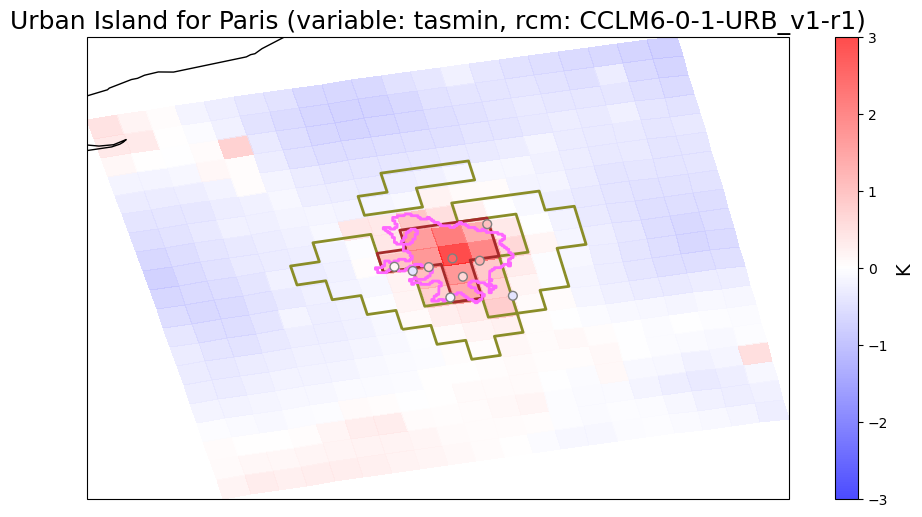

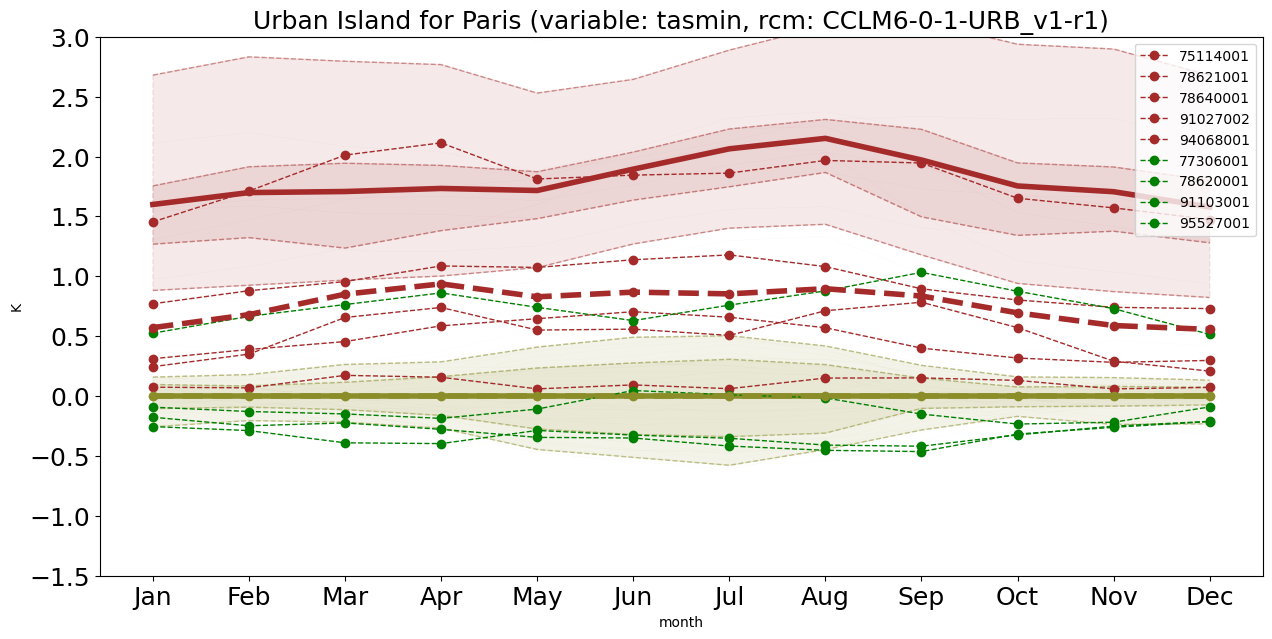

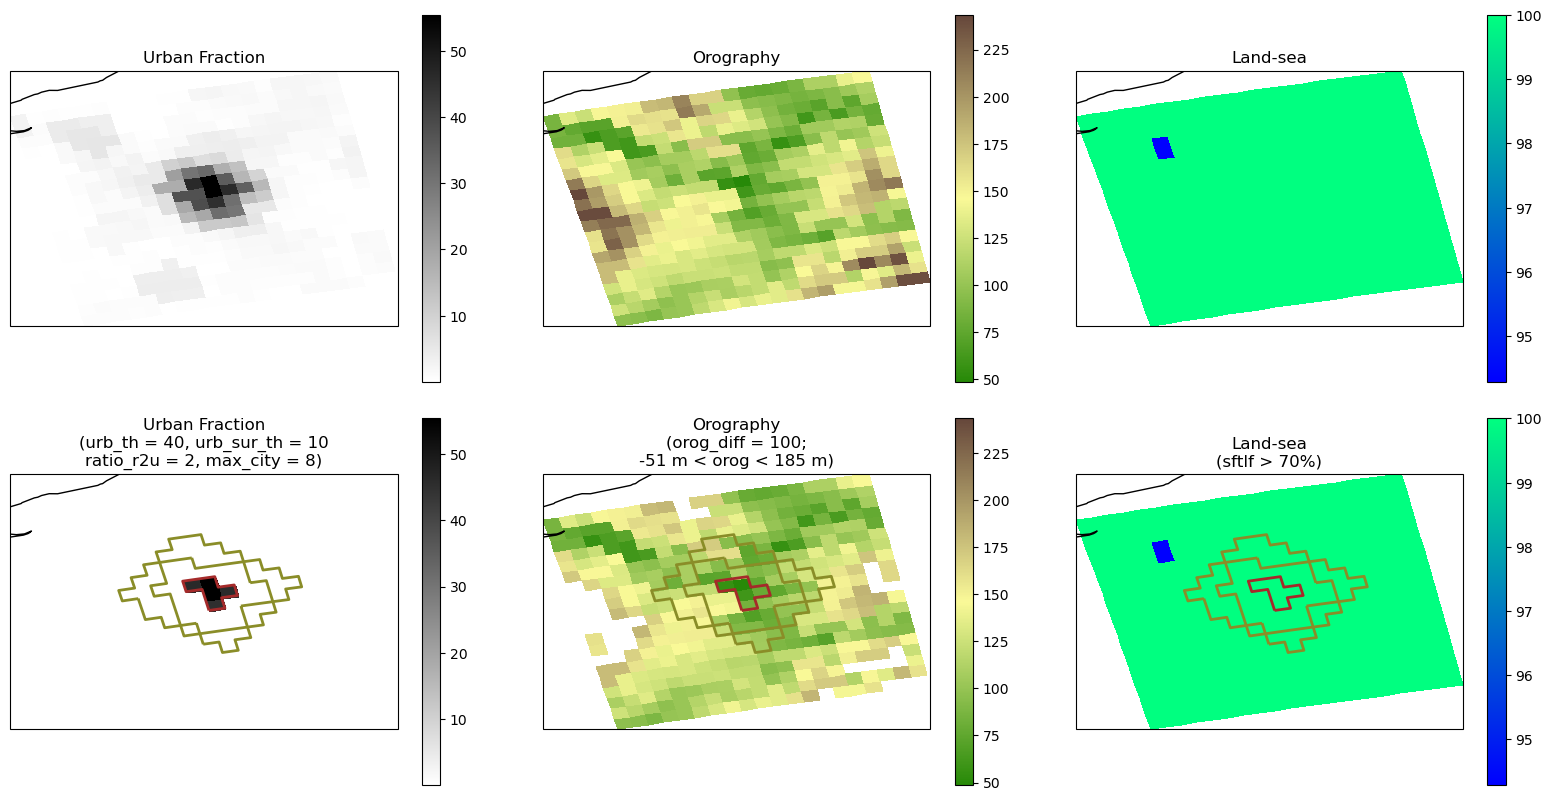

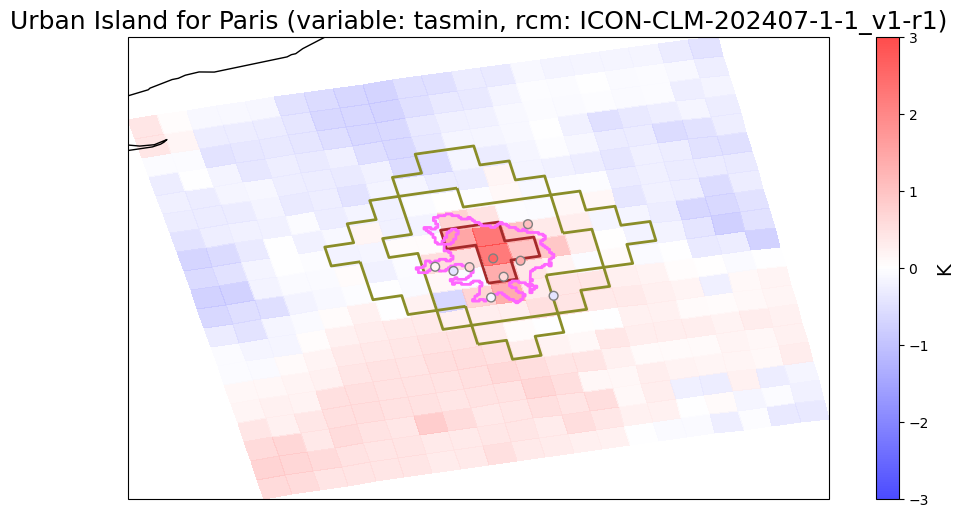

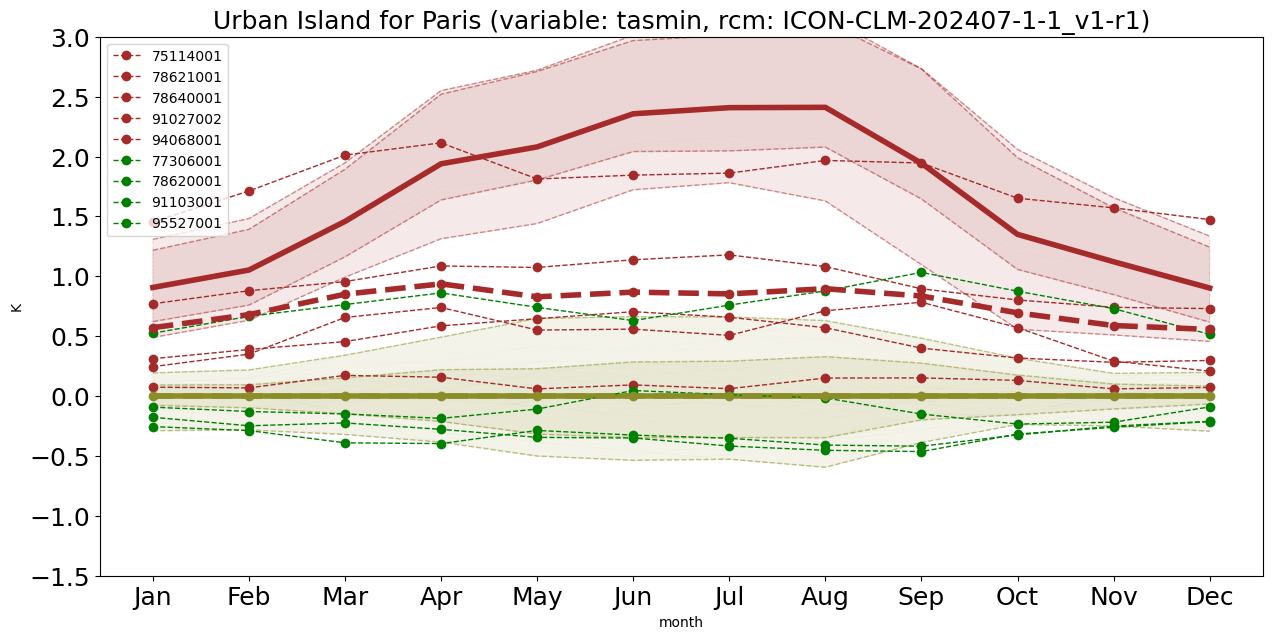

In [17]:
rcm_names = []
for dset, ds in dsets.items():

    ds = fix_360_longitudes(ds, lonname="lon")

    ds_sfturf = ds[[urban_var]].compute()
    ds_orog = ds[["orog"]].compute()
    ds_sftlf = ds[["sftlf"]].compute()
    try:
        rcm_name = ds.attrs["model_id"] + "_" + ds.attrs["rcm_version_id"]
    except Exception:
        rcm_name = ds.attrs["source_id"] + "_" + ds.attrs["version_realization"]

    rcm_names.append(rcm_name)

    # Add parameters to the function
    URBAN = UrbanVicinity(
        urban_sur_th=urban_sur_th,
        orog_diff=orog_diff,
        sftlf_th=sftlf_th,
        ratio_r2u=ratio_r2u,
        min_city_size=min_city_size,
        lon_city=lon_city,
        lat_city=lat_city,
        lon_lim=lon_lim,
        lat_lim=lat_lim,
        model=model,
        domain=domain,
        urban_th=urban_th,
        urban_var=urban_var,
    )

    # Crop area around de city
    ds_sfturf = URBAN.crop_area_city(ds=ds_sfturf, res=domain_resolution)
    ds_orog = URBAN.crop_area_city(ds=ds_orog, res=domain_resolution)
    ds_sftlf = URBAN.crop_area_city(ds=ds_sftlf, res=domain_resolution)
    # Define masks using the parameters above
    sfturf_mask, sfturf_sur_mask, orog_mask, sftlf_mask = URBAN.define_masks(
        ds_sfturf=ds_sfturf,
        ds_orog=ds_orog,
        ds_sftlf=ds_sftlf,
    )
    # Define rural vicinity areas
    urmask = URBAN.select_urban_vicinity(
        sfturf_mask=sfturf_mask,
        orog_mask=orog_mask,
        sftlf_mask=sftlf_mask,
        sfturf_sur_mask=sfturf_sur_mask,
    )
    # We can plot the masks and the urban vs vicinity areas. The latter are are passed via the `urban_areas` parameter. They are hidden if set to `None`.
    fig = URBAN.plot_static_variables(
        ds_sfturf=ds_sfturf,
        ds_orog=ds_orog,
        ds_sftlf=ds_sftlf,
        sfturf_mask=sfturf_mask,
        orog_mask=orog_mask,
        sftlf_mask=sftlf_mask,
        urban_areas=urmask,
    )
    plt.savefig(
        f"{save_figure_path}/CMIP6_Paris_static_{variable}_{rcm_name}.png",
        bbox_inches="tight",
    )

    ## Calculate Urban Heat Island (UHI)
    ds_RCM = ds[[variable]]
    ds_RCM = URBAN.crop_area_city(ds=ds_RCM, res=domain_resolution)

    # Load obs data
    output_file = "/mnt/CORDEX_CMIP6_tmp/aux_data/PARIS_surface_weather_data/Data_MF_1980-2017.csv"
    radious = 0.5
    stan_data = pd.read_csv(output_file)
    stan_data["code"] = stan_data["code"].astype(str)
    stan_data = stan_data.loc[stan_data["dist"] < radious]
    valid_obs, time_series_obs, ds_RCM_period = get_valid_timeseries(
        city,
        stan_data,
        ds_RCM,
        df_obs,
        variable,
        idate="1991-01-01",
        fdate="2020-12-31",
        divide=1,
    )
    valid_obs = inside_city(valid_obs, ucdb_city)

    ### Compute the annual cycle climatology of anomalies with respect to rural vicinity mean
    UHI = UrbanIsland(
        ds=ds_RCM[variable],
        urban_vicinity=urmask,
        rcm=rcm_name,
        anomaly="abs",
        obs_attributes=valid_obs,
        obs_timeseries=time_series_obs,
    )
    ## Plot the data
    fig = UHI.plot_UI_map(city_name=city, ucdb_city=ucdb_city, vmax=3)

    plt.savefig(
        f"{save_figure_path}/CMIP6_Paris_UHI_map_{variable}_{rcm_name}_{period.start}-{period.stop}.png",
        bbox_inches="tight",
    )
    fig = UHI.plot_UI_annual_cycle(
        percentiles=[5, 25], gridcell_series=True, city_name=city, vmax=3, vmin=-1.5
    )
    plt.savefig(
        f"{save_figure_path}/CMIP6_Paris_Annual_cycle_{variable}_{rcm_name}_{period.start}-{period.stop}.png",
        bbox_inches="tight",
    )

In [18]:
df_obs_Paris

NameError: name 'df_obs_Paris' is not defined

In [ ]:
rcm_names = np.sort(rcm_names)

In [ ]:
imgs = [
    Image.open(
        f"{save_figure_path}/CMIP6_Paris_UHI_map_{variable}_{rcm_name}_{period.start}-{period.stop}.png"
    )
    for rcm_name in rcm_names
]
imgs = [img.crop(img.getbbox()) for img in imgs]

w, h = imgs[0].size
final_img = Image.new("RGB", (1 * w, len(imgs) * h), "white")

for n_i, img in enumerate(imgs):
    final_img.paste(img, (0, n_i * h))

final_img.save(
    f"{save_figure_path}/CMIP6_Paris_UHI_map_{variable}_{period.start}-{period.stop}.png"
)

In [ ]:
imgs = [
    Image.open(
        f"{save_figure_path}/CMIP6_Paris_Annual_cycle_{variable}_{rcm_name}_{period.start}-{period.stop}.png"
    )
    for rcm_name in rcm_names
]
imgs = [img.crop(img.getbbox()) for img in imgs]

w, h = imgs[0].size
final_img = Image.new("RGB", (1 * w, len(imgs) * h), "white")

for n_i, img in enumerate(imgs):
    final_img.paste(img, (0, n_i * h))

final_img.save(
    f"{save_figure_path}/CMIP6_Paris_Annual_cycle_{variable}_{period.start}-{period.stop}.png"
)

In [ ]:
img1 = Image.open(
    f"{save_figure_path}/CMIP6_Paris_UHI_map_{variable}_{period.start}-{period.stop}.png"
)
img2 = Image.open(
    f"{save_figure_path}/CMIP6_Paris_Annual_cycle_{variable}_{period.start}-{period.stop}.png"
)

img1 = img1.crop(img1.getbbox())
img2 = img2.crop(img2.getbbox())

w1, h1 = img1.size
w2, h2 = img2.size

new_w2 = int(w2 * h1 / h2)
img2 = img2.resize((new_w2, h1), Image.LANCZOS)

final_img = Image.new("RGB", (w1 + w2, h1), "white")

final_img.paste(img1, (0, 0))
final_img.paste(img2, (w1, 0))

final_img.save(
    f"{save_figure_path}/CMIP6_Paris_{variable}_{period.start}-{period.stop}.png"
)

In [ ]:
final_img